<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/train/ctgov/TrainPhaseClassifier_06_Random_Forest_Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_annotations = pd.read_csv("/content/drive/MyDrive/data/all_annotations.csv")


In [4]:
with open("/content/drive/MyDrive/data/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [5]:
from nltk.tokenize import RegexpTokenizer

# Words and fractions and percentages
tok = RegexpTokenizer(r'\d+[\.,]\d+%?|[\w%]+|=|≤|≥|<|>')


def tokenise_text(page: str) -> list:
    """
    Tokenise the content of a single page
    :param page:
    """
    for word in tok.tokenize(page):
        yield word

def tokenise_text_and_lowercase(page: str) -> list:
    """
    Tokenise the content of a single page and return the lowercase of each token
    :param page:
    """
    for word in tok.tokenize(page):
        yield word.lower()

def tokenise_pages(pages):
    """
    Tokenises the lists of pages and returns a list of lists.
    This is a custom tokeniser as nunbers and percentages should not be split (e.g. 5.5%).

    :param pages: List of strings which each correspond to the content of a single page.
    :return: List of lists of tokens.
    """
    tokenised_pages = []

    for page in pages:
        tokens = []
        for word in tokenise_text(page):
            tokens.append(word)
        tokenised_pages.append(tokens)
    return tokenised_pages



def iterate_tokens(tokenised_pages):
    for page_no, tokens in enumerate(tokenised_pages):
        for token_no, token in enumerate(tokens):
            yield page_no, token_no, token

In [19]:
import spacy
from spacy.matcher import PhraseMatcher

import spacy

#nlp = spacy.load('en_core_web_sm', disable=['ner', 'tagger', 'parser', 'lemmatizer'])
nlp = spacy.blank("en")


phase_synonyms = {0: ['phase 0', 'pilot study'],
                  0.5: ['early phase i', 'early phase 1', 'early phase 1.0', 'phase 0.5'],
                  1: ['phase i', 'phase 1 b', 'phase 1', 'phase 1.0'],
                  1.5: ['phase i ii', 'phase 1 2', 'phase 1 2 a'],
                  2: ['phase ii', 'phase 2 b', 'phase 2', 'phase 2.0'],
                  2.5: ['phase 2.5', 'phase ii iii'],
                  3: ['phase iii', 'phase 3', 'phase 3.0'],
                  4: ['phase iv', 'phase 4', 'phase 4.0', 'phase 4 a', 'phase 4 b'],
                  }

phrase_matcher = PhraseMatcher(nlp.vocab)

for phase_number, synonyms in phase_synonyms.items():
    phases = [nlp.make_doc(text) for text in synonyms]

    phrase_matcher.add(f"Phase {phase_number}", None, *phases)


class PhaseExtractor:

    def process(self, tokenised_pages: list) -> tuple:
        """
        Identify the trial phase.
        :param tokenised_pages: List of lists of tokens of each page.
        :return: The prediction (str) and a map from phase to the pages it's mentioned in.
        """

        tokenised_pages = [[string.lower() for string in sublist] for sublist in tokenised_pages]

        phase_to_pages = {}

        for page_number, page_tokens in enumerate(tokenised_pages):
            doc = spacy.tokens.doc.Doc(
                nlp.vocab, words=page_tokens)
            phrase_matches = phrase_matcher(doc)
            for word, start, end in phrase_matches:
                phase_number = nlp.vocab.strings[word]
                if phase_number not in phase_to_pages:
                    phase_to_pages[phase_number] = []
                phase_to_pages[phase_number].append(page_number)

        phase_to_pages = sorted(phase_to_pages.items(), key=lambda v: len(v[1]), reverse=True)

        prediction = 0
        if len(phase_to_pages) > 0:
            prediction = float(phase_to_pages[0][0].split(" ")[1])

        return {"prediction": prediction, "pages": dict(phase_to_pages)}

        # return {"prediction": prediction, "pages": []}


In [20]:
df_train = df_annotations[df_annotations.train_val == "train"]

In [28]:
phase_map = {'Early Phase 1':0.5,
 'Not Applicable':0,
 'Phase 1':1,
 'Phase 1/Phase 2':1.5,
 'Phase 2':2,
 'Phase 2/Phase 3':2.5,
 'Phase 3':3,
 'Phase 4':4}

In [78]:
df_annotations_small = df_annotations.sample(1000)

In [79]:
X_train = []
y_train = [] 
X_val = []
y_val = []

for idx in range(len(df_annotations_small)):
  file_name = df_annotations_small.file.iloc[idx]
  if pd.isna(file_name):
    continue
    
  pages= file_to_pages[file_name]

  tokenised_pages = tokenise_pages(pages)
  gt = df_annotations_small.phase.iloc[idx]

  if pd.isna(gt):
    continue

  gt_float = float(phase_map[gt])
  
  
  tokenised_pages = [[string.lower() for string in sublist] for sublist in tokenised_pages]

  phase_to_pages = {}

  for page_number, page_tokens in enumerate(tokenised_pages):
      doc = spacy.tokens.doc.Doc(
          nlp.vocab, words=page_tokens)
      phrase_matches = phrase_matcher(doc)
      for word, start, end in phrase_matches:
          phase_number = nlp.vocab.strings[word]
          if phase_number not in phase_to_pages:
              phase_to_pages[phase_number] = []
          phase_to_pages[phase_number].append(page_number)

  phase_to_pages = sorted(phase_to_pages.items(), key=lambda v: len(v[1]), reverse=True)

  for idx, (phase, pages) in enumerate(phase_to_pages):
    phase_float = float(re.sub(r'\D', '', phase))
    feat_vect = [len(pages), min(pages), max(pages), idx]
    y = int(phase_float == gt_float)

    if df_annotations_small.train_val.iloc[idx] == "train":
      X_train.append(feat_vect)
      y_train.append(y)
    else:
      X_val.append(feat_vect)
      y_val.append(y)

  # if len(X_train) > 10000:
  #   break

In [80]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_train)
y_val = np.asarray(y_train)

In [81]:
from sklearn.linear_model import LogisticRegression

In [82]:
m = LogisticRegression()

In [83]:
m.fit(X_train, y_train)

LogisticRegression()

In [84]:
m.coef_

array([[-0.00954524, -0.05893146,  0.00188415, -1.37675775]])

In [85]:
y_train

array([1, 0, 1, ..., 1, 0, 0])

In [85]:
y_pred = m.predict(X_val)

In [87]:
from sklearn.metrics import accuracy_score

In [88]:
accuracy_score(y_val, y_pred)

0.8016643550624133

In [89]:
y_pred_proba = m.predict_proba(X_val)

In [91]:
from sklearn.ensemble import RandomForestClassifier

In [92]:
m = RandomForestClassifier()

In [93]:
m.fit(X_train, y_train)

RandomForestClassifier()

In [94]:
y_pred = m.predict(X_val)

In [95]:
accuracy_score(y_val, y_pred)

0.9754969949144706

In [96]:
y_pred_proba = m.predict_proba(X_val)

In [98]:
import bz2
with bz2.open("phase_rf_classifier", "wb") as f:
    pkl.dump(m, f)

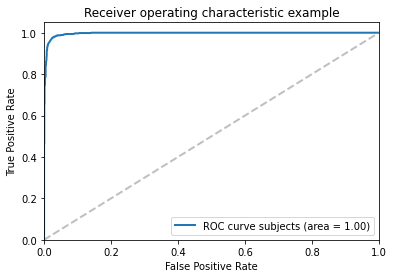

In [97]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
    
fpr, tpr, _ = roc_curve(y_val, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(
    fpr,
    tpr,
    # color="darkorange",
    lw=lw,
    label=f"ROC curve subjects (area = {roc_auc:0.2f})"
)
plt.plot([0, 1], [0, 1], color="gray", alpha=0.5, lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")t
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()